In [212]:
import pandas as pd
import numpy as np
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

In [213]:
import random
random.seed(42)

In [214]:
DATA_PATH = "../ml-latest-small"

ratings = pd.read_csv(os.path.join(DATA_PATH, "ratings.csv"))
movies = pd.read_csv(os.path.join(DATA_PATH, "movies.csv"))
tags = pd.read_csv(os.path.join(DATA_PATH, "tags.csv"))

# Unconstrained Matrix Factorisation based Collaborative Filtering (week 7)

In [215]:
df_ecommerce= pd.read_json('../1_ecommerce.jsonl', lines=True)

# for each session, we will create a list of items that the user has clicked on, removing duplicates
clicks_items_list = []
carts_items_list = []
orders_items_list = []

for events in df_ecommerce.events:
    clicks = []
    carts = []
    orders = []
    for e in events:
        if e['type'] == 'clicks':
            clicks.append(e['aid'])
        if e['type'] == 'carts':
            carts.append(e['aid'])
        if e['type'] == 'orders':
            orders.append(e['aid'])

    clicks_items_list.append(list(clicks))
    carts_items_list.append(list(carts))
    orders_items_list.append(list(orders))

df_ecommerce['clicks'] = clicks_items_list
df_ecommerce['carts'] = carts_items_list
df_ecommerce['orders'] = orders_items_list
df = df_ecommerce.drop(columns=["events"], axis=1)

clicks_length = df_ecommerce['clicks'].apply(len)
carts_length = df_ecommerce['carts'].apply(len)
orders_length = df_ecommerce['orders'].apply(len)

# takes only the session with items length higher than 20
df_truncated = df[df['clicks'].apply(lambda x: len(x) > 10)]
df = df_truncated.copy()
# redefine index
df.reset_index(drop=True, inplace=True)

# Explode each column (clicks, carts, orders)
df_clicks = df[['session', 'clicks']].explode('clicks').rename(columns={'clicks': 'item'}).dropna(subset=['item'])
df_carts = df[['session', 'carts']].explode('carts').rename(columns={'carts': 'item'}).dropna(subset=['item'])
df_orders = df[['session', 'orders']].explode('orders').rename(columns={'orders': 'item'}).dropna(subset=['item'])

# Concatenate the exploded dataframes
df_concat = pd.concat([df_clicks, df_carts, df_orders])

# Create a new column for each category indicating whether the item is present in that category
df_concat['click'] = df_concat['item'].isin(df_clicks['item']).astype(int)
df_concat['cart'] = df_concat['item'].isin(df_carts['item']).astype(int)
df_concat['order'] = df_concat['item'].isin(df_orders['item']).astype(int)

# Drop duplicates based on session and item
df_concat = df_concat.drop_duplicates(subset=['session', 'item'])

In [216]:
def sgd_matrix_factorization(df, k=10, alpha=0.01, lambda_reg=0.1, num_epochs=20, w_click=1, w_cart=3, w_order=5, test_size=0.2, validation_size=0.1):
    # Map session (users) and items to consecutive indices
    users = {u: i for i, u in enumerate(df['session'].unique())}
    items = {i: j for j, i in enumerate(df['item'].unique())}

    num_users = len(users)
    num_items = len(items)

    # Initialize U, V, and biases
    U = np.random.rand(num_users, k)
    V = np.random.rand(num_items, k)
    b_u = np.zeros(num_users)
    b_i = np.zeros(num_items)
    b = 0  # Global bias

    # Create (u, i, r_ui) tuples for all interactions
    data = []

    # iter throw all the rows of the dataframe
    # and create a list of tuples (user, item, rating)
    # Assign ratings to interactions
    for _, row in df.iterrows():
        u = users[row['session']]
        i = items[row['item']]

        # if this user has perform an action on this item, we assign a rating based on the action
        # type starting from the most important one
        # (order > cart > click)
        if row['order'] > 0:
            r_ui = w_order
        elif row['cart'] > 0:
            r_ui = w_cart
        elif row['click'] > 0:
            r_ui = w_click
        else:
            continue  # Skip interactions with no recorded action

        data.append((u, i, r_ui))

    # Split the data into training, validation, and test sets
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=validation_size, random_state=42)

    # Compute global bias as the mean rating of the training set
    if train_data:
        b = np.mean([r for _, _, r in train_data])

    print("Datasets created! Starting training...")

    # Training using SGD
    losses = []
    val_losses = []

    for epoch in range(num_epochs):
        np.random.shuffle(train_data)  # Shuffle data to improve convergence
        total_loss = 0
        total_val_loss = 0

        U_temp = U.copy()
        V_temp = V.copy()

        # Training phase
        for u, i, r_ui in train_data:
            # Predict the rating using the current model parameters
            # b is the global bias, b_u[u] is the user bias, b_i[i] is the item bias
            pred = b + b_u[u] + b_i[i] + np.dot(U[u, :], V[i, :])

            # Calculate the error
            e_ui = r_ui - pred  # Error

            # Update biases
            # alpha is the learning rate, lambda_reg is the regularization parameter
            b_u[u] += alpha * (e_ui - lambda_reg * b_u[u])
            b_i[i] += alpha * (e_ui - lambda_reg * b_i[i])

            # Update latent factors using temporary matrices
            U_temp[u, :] += alpha * (e_ui * V[i, :] - lambda_reg * U[u, :])
            V_temp[i, :] += alpha * (e_ui * U[u, :] - lambda_reg * V[i, :])

            total_loss += e_ui ** 2  # Sum of squared errors
        total_loss /= len(train_data)
        total_loss = np.sqrt(total_loss)

        # Copy back updated matrices
        U = U_temp
        V = V_temp

        # Validation phase (calculate validation loss)
        for u, i, r_ui in val_data:
            pred = b + b_u[u] + b_i[i] + np.dot(U[u, :], V[i, :])
            e_ui = r_ui - pred  # Error
            total_val_loss += e_ui ** 2
        total_val_loss /= len(val_data)
        total_val_loss = np.sqrt(total_val_loss)

        # Append losses for the current epoch
        losses.append(total_loss)
        val_losses.append(total_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, RMSE Train Loss: {total_loss:.4f}, RMSE Val Loss: {total_val_loss:.4f}")

    # Test phase (calculate test loss)
    test_loss = 0
    for u, i, r_ui in test_data:
        pred = b + b_u[u] + b_i[i] + np.dot(U[u, :], V[i, :])
        e_ui = r_ui - pred  # Error
        test_loss += e_ui ** 2
    test_loss /= len(test_data)
    test_loss = np.sqrt(test_loss)

    print(f"Final Test RMSE: {test_loss:.4f}")

    return U, V, b_u, b_i, b, losses, val_losses, train_data, test_data, val_data

In [217]:
W_click = 1
W_cart = 2
W_order = 3

all_possible_rates = [W_click, W_cart, W_order]

In [ ]:


U, V, b_u, b_i, b, _, _, train_data_mf, test_data_mf, val_data_mf = sgd_matrix_factorization(df_concat, k=5, alpha=0.001, num_epochs=1, w_click=W_click, w_cart=W_cart, w_order=W_order)



Datasets created! Starting training...


In [ ]:
df_train_data_mf = pd.DataFrame(train_data_mf, columns=['session', 'item', 'rating'])
df_test_data_mf = pd.DataFrame(test_data_mf, columns=['session', 'item', 'rating'])
df_val_data_mf = pd.DataFrame(val_data_mf, columns=['session', 'item', 'rating'])

In [ ]:
all_data = pd.concat([df_test_data_mf], axis=0)

# Estrai gli indici in array NumPy
sessions = all_data['session'].values
items = all_data['item'].values

# Calcola le predizioni in maniera vettoriale:
# La formula è: pred = b + b_u[u] + b_i[i] + np.dot(U[u, :], V[i, :])
predicted_ratings = b + b_u[sessions] + b_i[items] + np.einsum('ij,ij->i', U[sessions], V[items])

# Crea il DataFrame delle predizioni copiando all_data e aggiungendo la colonna calcolata
df_predictions_mf = all_data.copy()
df_predictions_mf['predicted'] = predicted_ratings

# rename the columns rating to rating_ordinal
#df_predictions_mf.rename(columns={'rating': 'rating_ordinal'}, inplace=True)

min_possible_rating = min(all_possible_rates)
max_possible_rating = max(all_possible_rates)

# Convert the predicted ratings to integers
df_predictions_mf['predicted'] = df_predictions_mf['predicted'].round().astype(int)

# Normalize the predicted ratings to the range [min_possible_rating, max_possible_rating]
df_predictions_mf['predicted'] = df_predictions_mf['predicted'].apply(lambda x: min(max(x, min_possible_rating), max_possible_rating))
df_predictions_mf

,session,item,rating,predicted
0,10917,15793,3,3
1,32821,235650,1,3
2,90215,241700,1,3
3,14629,135192,1,3
4,52104,772,3,3
...,...,...,...,...
144953,78218,63967,2,3
144954,55648,43291,3,2
144955,50441,51136,3,3
144956,110168,116541,2,3


In [ ]:
df_mf = df_predictions_mf.copy()

# Naive Bayes CF Model Based (Week6)

Qui ho ridotto a 2 classi in modo da essere uguale alla week8 (content-based)

```python
user_data['label'] = user_data['rating'].apply(lambda r: 1 if r >= 4 else (0 if r <= 2 else None))
```

In [186]:
df_ratings = ratings.copy()

df_ratings.loc[df_ratings['rating'] <= 2, 'rating_ordinal'] = "Don't like"
df_ratings.loc[df_ratings['rating'] >= 4, 'rating_ordinal'] = "Like"

ratings_ordinals = df_ratings['rating_ordinal'].unique()

all_films = df_ratings["movieId"].unique()

In [187]:
# Prendi solo le righe con rating_ordinal noto
df_known = df_ratings.dropna(subset=['rating_ordinal'])

# Fai lo split tra train e test
# df_train, df_test = train_test_split(df_known, test_size=0.05, random_state=42) #3106 tuples
df_train_cf, df_test_cf = train_test_split(df_known, test_size=0.005, random_state=42) #311 tuples ~1min

# Ricrea la matrice user-movie SOLO con i dati del training set
df_train_user_movie_cf = df_train_cf.pivot(index='userId', columns='movieId', values='rating_ordinal')

# Il test sarà una lista di (userId, movieId, rating_ordinal) da prevedere
df_test_cf = df_test_cf[['userId', 'movieId', 'rating_ordinal']]

In [188]:
def test_naive_cf_model_based(df_test, df_train_user_movie):

    df_predictions = df_test.copy()

    for idx, row in enumerate(df_predictions.itertuples()):
        userId = row.userId
        movieId = row.movieId

        # Film visti dall'utente, dai dati di TRAIN
        try:
            films_seen = df_train_user_movie.loc[userId].dropna().index
        except KeyError:
            # Utente non presente nel train (cold start) → skip
            continue

        category_probs = {}

        for category in ratings_ordinals:
            df_current_movie = df_train_cf[(df_train_cf['movieId'] == movieId)]
            df_current_movie_category = df_current_movie[(df_current_movie['rating_ordinal'] == category)]

            if len(df_current_movie) == 0:
                continue  # impossibile stimare, nessuno ha votato il film

            users_with_category = df_current_movie_category['userId'].unique()

            p_cat = len(df_current_movie_category) / len(df_current_movie)
            probs = [p_cat]

            for film_seen in films_seen:
                try:
                    assigned_rating = df_train_user_movie.loc[userId, film_seen]
                except KeyError:
                    continue  # Film non presente per quell’utente

                df_seen_movie = df_train_cf[df_train_cf['movieId'] == film_seen]
                df_seen_movie_filtered = df_seen_movie[df_seen_movie['userId'].isin(users_with_category)]
                df_seen_movie_same_rating = df_seen_movie_filtered[df_seen_movie_filtered['rating_ordinal'] == assigned_rating]

                if len(df_seen_movie_filtered) == 0:
                    continue

                p_cond = len(df_seen_movie_same_rating) / len(df_seen_movie_filtered)
                probs.append(p_cond)

            category_probs[category] = np.prod(probs)

        if category_probs:
            predicted = max(category_probs.items(), key=lambda x: x[1])[0]
            df_predictions.loc[(df_predictions['userId'] == userId) & (df_predictions['movieId'] == movieId), 'predicted'] = predicted

        if idx % 50 == 0:
            print(f"Processed {idx}/{len(df_predictions)}")

    return df_predictions

In [189]:
df_predictions_cf = test_naive_cf_model_based(df_test_cf, df_train_user_movie_cf)

Processed 0/311
Processed 50/311
Processed 100/311
Processed 150/311
Processed 200/311
Processed 250/311
Processed 300/311


In [190]:
df_predictions_cf.head(10)

,userId,movieId,rating_ordinal,predicted
66214,426,2797,Like,Like
73518,474,1394,Like,Like
15301,100,11,Like,Like
23465,160,2078,Like,Like
77851,483,79242,Like,Like
22670,155,2959,Like,Like
75461,477,374,Don't like,Like
22474,153,2571,Don't like,Like
90090,586,1784,Like,Like
51118,330,2739,Like,Like


In [191]:
from sklearn.metrics import classification_report

# Skipping the NaN values (where we don't have that user in train / film without ratings)
df_predictions_cf.dropna(subset=['predicted'], inplace=True)

In [192]:
df_predictions_cf['rating_label'] = df_predictions_cf['rating_ordinal'].map({
    "Don't like": 0,
    "Like": 1
})

df_predictions_cf['pred_label'] = df_predictions_cf['predicted'].map({
    "Don't like": 0,
    "Like": 1
})

print(classification_report(df_predictions_cf['rating_label'], df_predictions_cf['pred_label']))

              precision    recall  f1-score   support

           0       0.56      0.08      0.14        60
           1       0.81      0.98      0.89       238

    accuracy                           0.80       298
   macro avg       0.68      0.53      0.52       298
weighted avg       0.76      0.80      0.74       298



# Bayes Classification Content-based (week 8)

In [193]:
## 🧹 Preprocess Movie Metadata
tags_agg = tags.copy().groupby("movieId")["tag"].apply(lambda x: " ".join(x)).reset_index()
movies_df = movies.copy().merge(tags_agg, on="movieId", how="left")
movies_df["tag"] = movies_df["tag"].fillna("")

#### 1. User-Specific Naive Bayes Recommender

In [194]:
# Clean the title by removing the year in parentheses
def clean_title(title):
    return re.sub(r'\s*\(\d{4}\)', '', title)

metadata = movies_df[["movieId", "title", "genres"]]
metadata.loc[:, 'title'] = metadata['title'].apply(clean_title)

mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(metadata['genres'].str.split('|'))
# Create a DataFrame with the encoded genres
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
# Concatenate the original metadata with the encoded genres
metadata = pd.concat([metadata[['movieId', 'title']], genres_df], axis=1)

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')

# Create a preprocessor that transforms the movie metadata:
# - Applies TF-IDF vectorization to the cleaned 'title' column to extract textual features.
# - Passes through the binary genre columns (already transformed by MultiLabelBinarizer).
# - Drops any remaining columns that are not explicitly selected.
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf, 'title'),
        ('genres', 'passthrough', genres_df.columns)
    ],
    remainder='drop'
)

In [195]:
def predict_single_movie(user_id, movie_id, ratings_train):
    ratings = ratings_train.copy()

    # Step 1: Prepare user data
    user_ratings = ratings[ratings['userId'] == user_id]
    user_data = pd.merge(user_ratings, metadata, on='movieId')

    # Step 2: Create binary labels
    user_data['label'] = user_data['rating'].apply(lambda r: 1 if r >= 4 else (0 if r <= 2 else None))
    user_data = user_data.dropna(subset=['label'])
    user_data['label'] = user_data['label'].astype(int)

    if user_data.empty:
        print("User has insufficient data.")
        return None

    # Step 3: Train the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', MultinomialNB())
    ])

    X_train = user_data.drop(columns=['userId', 'rating', 'label', 'timestamp', 'rating_ordinal'])
    y_train = user_data['label']

    pipeline.fit(X_train, y_train)

    # Step 4: Check if the movie has already been watched
    if movie_id in user_ratings['movieId'].values:
        print("The movie has already been watched by the user.")
        return None

    # Step 5: Extract features of the requested movie
    movie_row = metadata[metadata['movieId'] == movie_id]

    if movie_row.empty:
        print("Movie ID not found in the metadata.")
        return None

    input_cols = list(X_train.columns)
    movie_features = movie_row[input_cols]

    # Step 6: Predict the probability of liking the movie
    probs = pipeline.predict_proba(movie_features)[0]  # P(liked | features)
    if len(probs) < 2:
        print(f"The model for user {user_id} has seen only one class (not like/like).")
        return None
    else:
        prob = probs[1]

    return "Like" if prob >= 0.5 else "Don't like"

In [196]:
chosen_user = random.choice(ratings['userId'].unique())
chosen_film = random.choice(metadata['movieId'].unique())

predict_single_movie(user_id=chosen_user, movie_id=chosen_film, ratings_train=df_train_cf)

'Like'

#### 2. Global Content-Based Recommender (Single Model for All Users)

In [197]:
metadata_with_tags = metadata.merge(movies_df[["movieId", "tag"]], on='movieId', how='left')

preprocessor_global = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf, 'title'),
        ('genres', 'passthrough', genres_df.columns),
        ('tfidf_tag', tfidf, 'tag')
    ],
    remainder='drop'
)

In [198]:
def train_global_model(ratings_train):
    ratings = ratings_train.copy()
    # Step 1: Prepare data
    data = pd.merge(ratings, metadata_with_tags, on='movieId')

    # Step 2: Create binary labels
    data['label'] = data['rating'].apply(lambda r: 1 if r >= 4 else (0 if r <= 2 else None))
    data = data.dropna(subset=['label'])
    data['label'] = data['label'].astype(int)

    # Step 3: Train the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor_global),
        ('classifier', MultinomialNB())
    ])

    X = data.drop(columns=['userId', 'movieId', 'rating', 'label', 'timestamp', 'rating_ordinal'])
    y = data['label']

    model = pipeline.fit(X, y)
    return model, X.columns

model_global, train_columns = train_global_model(df_train_cf)

def recommend_global(user_id, movie_id, ratings_train):
    ratings = ratings_train.copy()

    # Step 4: Check if the movie has already been watched
    user_ratings = ratings[ratings['userId'] == user_id]
    if movie_id in user_ratings['movieId'].values:
        print("The movie has already been watched by the user.")
        return None

    # Step 5: Extract features of the requested movie
    movie_row = metadata_with_tags[metadata_with_tags['movieId'] == movie_id]

    if movie_row.empty:
        print("Movie ID not found in the metadata.")
        return None
    movie_features = movie_row[train_columns]

    # Step 6: Predict the probability of liking the movie
    probs = model_global.predict_proba(movie_features)[0]  # P(liked | features)
    if len(probs) < 2:
        print(f"The model for user {user_id} has seen only one class (not like/like).")
        return None
    else:
        prob = probs[1]

    return "Like" if prob >= 0.5 else "Don't like"

In [199]:
recommend_global(user_id=chosen_user, movie_id=chosen_film, ratings_train=df_train_cf)

'Like'

In [200]:
def test_naive_cf_content_based(df_param, df_train):
    df_tmp = df_param.copy()

    preds_user = []
    preds_global = []
    for idx, row in enumerate(df_tmp.itertuples()):
        userId = row.userId
        movieId = row.movieId

        pred_user = predict_single_movie(userId, movieId, ratings_train=df_train)
        pred_global = recommend_global(userId, movieId, ratings_train=df_train)

        preds_user.append(pred_user)
        preds_global.append(pred_global)
        # df_tmp.loc[(df_predictions['userId'] == userId) & (df_predictions['movieId'] == movieId), 'pred_user'] = pred_user
        # df_tmp.loc[(df_predictions['userId'] == userId) & (df_predictions['movieId'] == movieId), 'pred_glob'] = pred_global

    return preds_user, preds_global

In [201]:
df_predictions_cf.head()

,userId,movieId,rating_ordinal,predicted,rating_label,pred_label
66214,426,2797,Like,Like,1,1
73518,474,1394,Like,Like,1,1
15301,100,11,Like,Like,1,1
23465,160,2078,Like,Like,1,1
77851,483,79242,Like,Like,1,1


In [202]:
u, g = test_naive_cf_content_based(df_predictions_cf, df_train=df_train_cf)

The model for user 586 has seen only one class (not like/like).
The model for user 519 has seen only one class (not like/like).
The model for user 74 has seen only one class (not like/like).
The model for user 74 has seen only one class (not like/like).
The model for user 72 has seen only one class (not like/like).
The model for user 60 has seen only one class (not like/like).
The model for user 319 has seen only one class (not like/like).
The model for user 523 has seen only one class (not like/like).
The model for user 169 has seen only one class (not like/like).
The model for user 533 has seen only one class (not like/like).
The model for user 348 has seen only one class (not like/like).
The model for user 43 has seen only one class (not like/like).
The model for user 49 has seen only one class (not like/like).
The model for user 171 has seen only one class (not like/like).
The model for user 142 has seen only one class (not like/like).
The model for user 106 has seen only one class

In [203]:
# create one df containing userId, movieId, rating_ordinal, predicted_user
# create another df containing userId, movieId, rating_ordinal, predicted_global
df_predictions_cf_format = df_predictions_cf.copy()
df_predictions_cf_format.rename(columns={'rating_ordinal': 'rating'}, inplace=True)
df_predictions_user = df_predictions_cf_format.copy()
df_predictions_user['predicted'] = u

df_predictions_global = df_predictions_cf_format.copy()
df_predictions_global['predicted'] = g

In [204]:
df_predictions_user

,userId,movieId,rating,predicted,rating_label,pred_label
66214,426,2797,Like,Like,1,1
73518,474,1394,Like,Like,1,1
15301,100,11,Like,Like,1,1
23465,160,2078,Like,Like,1,1
77851,483,79242,Like,Like,1,1
...,...,...,...,...,...,...
64078,414,6155,Don't like,Like,0,1
20227,132,30749,Like,Like,1,1
56666,377,150,Like,Like,1,1
51149,330,4011,Like,Like,1,1


In [205]:
df_global_nb = df_predictions_global.copy()
# map like dislike to 1 and 0 in predicted and rating columns
df_global_nb['predicted'] = df_global_nb['predicted'].map({
    "Don't like": 0,
    "Like": 1
})

df_global_nb['rating'] = df_global_nb['rating'].map({
    "Don't like": 0,
    "Like": 1
})

df_global_nb.dropna(subset=['predicted'], inplace=True)
df_global_nb['predicted'] = df_global_nb['predicted'].astype(int)
df_global_nb['rating'] = df_global_nb['rating'].astype(int)


df_user_nb = df_predictions_user.copy()
# map like dislike to 1 and 0 in predicted and rating columns
df_user_nb['predicted'] = df_user_nb['predicted'].map({
    "Don't like": 0,
    "Like": 1
})

df_user_nb['rating'] = df_user_nb['rating'].map({
    "Don't like": 0,
    "Like": 1
})

df_user_nb.dropna(subset=['predicted'], inplace=True)
df_user_nb['predicted'] = df_user_nb['predicted'].astype(int)
df_user_nb['rating'] = df_user_nb['rating'].astype(int)

In [206]:
len(u), len(df_predictions_cf)

(298, 298)

# Evaluation

In [ ]:
import importlib
import eval_functions
importlib.reload(eval_functions)

# Importa le funzioni di valutazione dal modulo esterno
from eval_functions import (
    evaluate_rating_predictions,
    analyze_long_tail_effect,
    plot_avg_error_by_genre,
    plot_avg_error_by_popularity,
    evaluate_ranking_spearman,
    evaluate_topk,
    plot_precision_recall_roc,
    evaluate_random_recommender
)


📊 Risultati per: Global Naive Bayes


,userId,movieId,rating,predicted,rating_label,pred_label
66214,426,2797,1,1,1,1
73518,474,1394,1,1,1,1
15301,100,11,1,1,1,1
23465,160,2078,1,1,1,1
77851,483,79242,1,1,1,1
22670,155,2959,1,1,1,1
75461,477,374,0,1,0,1
22474,153,2571,0,1,0,1
90090,586,1784,1,1,1,1
51118,330,2739,1,1,1,1


📌 Accuracy: {'MAE': 0.2181208053691275, 'RMSE': 0.4670340516162901, 'Accuracy': 0.7818791946308725}
🐍 Long Tail Error:
popularity
head    0.218121
Name: error, dtype: float64
👤 Utente campione: 64
🎯 Top-K: {'Precision@k': 1.0, 'Recall@k': 1.0, 'F1@k': 1.0}
🔗 Spearman correlation: nan


c:\Users\adriano.cicco\Documents\GitHub\DataAnaCla25\flipped_9\eval_functions.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(user_ratings, predicted_ratings).correlation
c:\Users\adriano.cicco\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


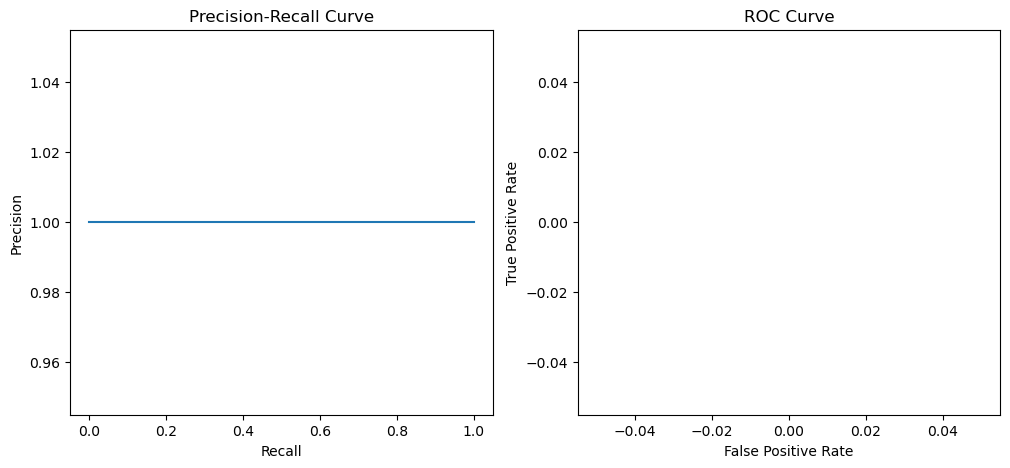


📊 Risultati per: User Naive Bayes


,userId,movieId,rating,predicted,rating_label,pred_label
66214,426,2797,1,1,1,1
73518,474,1394,1,1,1,1
15301,100,11,1,1,1,1
23465,160,2078,1,1,1,1
77851,483,79242,1,1,1,1
22670,155,2959,1,1,1,1
75461,477,374,0,1,0,1
22474,153,2571,0,0,0,1
51118,330,2739,1,1,1,1
38298,263,1357,1,1,1,0


📌 Accuracy: {'MAE': 0.18840579710144928, 'RMSE': 0.4340573661412156, 'Accuracy': 0.8115942028985508}
🐍 Long Tail Error:
popularity
head    0.188406
Name: error, dtype: float64
👤 Utente campione: 177
🎯 Top-K: {'Precision@k': 0.6666666666666666, 'Recall@k': 1.0, 'F1@k': 0.8}
🔗 Spearman correlation: nan


c:\Users\adriano.cicco\Documents\GitHub\DataAnaCla25\flipped_9\eval_functions.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(user_ratings, predicted_ratings).correlation


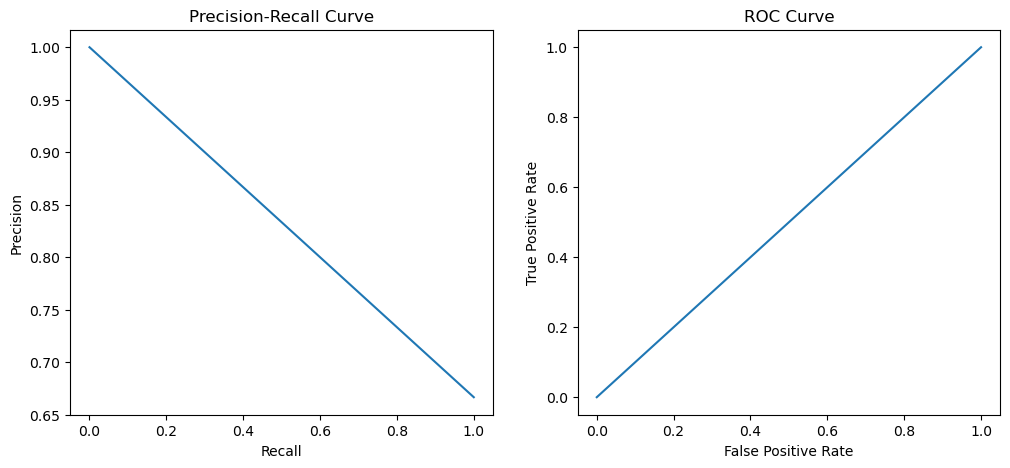


📊 Risultati per: Matrix Factorization


,session,item,rating,predicted
0,10917,15793,3,3
1,32821,235650,1,3
2,90215,241700,1,3
3,14629,135192,1,3
4,52104,772,3,3
5,100088,113662,1,3
6,72378,68148,3,3
7,97565,43078,2,3
8,39894,265494,1,3
9,83330,221472,1,3


📌 Accuracy: {'MAE': 1.0959609087803475, 'RMSE': 1.3372986048636732, 'Accuracy': 0.5764823531554383}
🐍 Long Tail Error:
popularity
head         0.920044
long_tail    1.634888
Name: error, dtype: float64
👤 Utente campione: 12946
🎯 Top-K: {'Precision@k': 0.5, 'Recall@k': 0.5, 'F1@k': 0.5}
🔗 Spearman correlation: 0.025


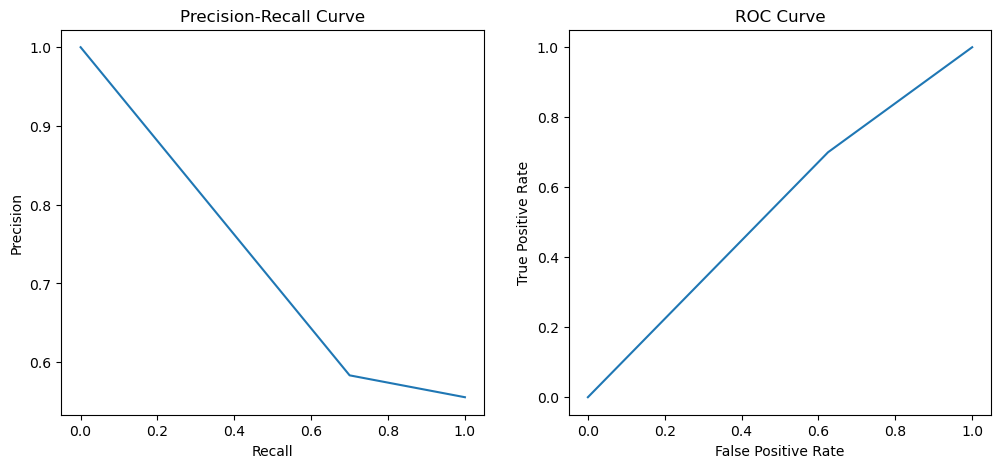

In [ ]:
models_info = [
    {
        'model_name': 'Global Naive Bayes',
        'df': df_global_nb,
        'user_column': 'userId',
        'item_column': 'movieId',
        'threshold': 0.5,  # Poiché i rating sono mappati in 0/1
        'genre_test': False,

    },
    {
        'model_name': 'User Naive Bayes',
        'df': df_user_nb,
        'user_column': 'userId',
        'item_column': 'movieId',
        'threshold': 0.5,  # Poiché i rating sono mappati in 0/1
        'genre_test': True,
    },
    {
        'model_name': 'Matrix Factorization',
        'df': df_mf,
        'user_column': 'session',
        'item_column': 'item',
        'threshold': 2.0,  # Ad esempio, se la scala dei rating è diversa (es. [1, 2, 3])
        'genre_test': True,
    }
]


for model_info in models_info:
    name = model_info['model_name']
    df = model_info['df']
    user_column = model_info['user_column']
    item_column = model_info['item_column']
    threshold = model_info['threshold']

    print(f"\n============================")
    print(f"📊 Risultati per: {name}")

    display(df.head(10))

    # Valutazione classica
    metrics = evaluate_rating_predictions(df['rating'].dropna(), df['predicted'].dropna(), threshold)
    print("📌 Accuracy:", metrics)

    # Long Tail
    long_tail = analyze_long_tail_effect(df.dropna(subset=['rating']),'predicted', item_column=item_column)
    print("🐍 Long Tail Error:")
    print(long_tail)

    # Top-K Example su un utente qualsiasi con almeno 2 rating
    # Seleziona un utente casuale con almeno 2 rating

    user_counts = df[user_column].value_counts()
    eligible_users = user_counts[user_counts > 1].index.tolist()
    if not eligible_users:
        print("Nessun utente con almeno 2 rating trovato.")
        continue

    sample_user = random.choice(eligible_users)
    print(f"👤 Utente campione: {sample_user}")

    user_df = df[df[user_column] == sample_user].dropna(subset=['rating'])

    if not user_df.empty:
        # costruiamo y_true e scores
        true_items = set(user_df[user_df['rating'] >= threshold][item_column])
        movie_ids = user_df[item_column].tolist()
        scores = user_df['predicted'].tolist()
        y_true = [1 if m in true_items else 0 for m in movie_ids]

        topk = evaluate_topk(y_true, scores, k=10)
        print("🎯 Top-K:", topk)

        # Correlazione ranking
        spearman = evaluate_ranking_spearman(user_df['rating'], user_df['predicted'])
        print(f"🔗 Spearman correlation: {spearman:.3f}")

        # Curve
        plot_precision_recall_roc(y_true, scores)
